## Network analysis and partial correlations

In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
import bammm.bammm as mm
import pingouin as pg
import networkx as nx


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))

##### VERY IMPORTANT ####
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

/data/drive/postdoc/Project4_covid


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
### Meta parameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 44
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==44:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 

State seveirty NaNs: 198 out of entries: 5825


In [3]:

# Define the conditions and corresponding values
conditions = [
    df['session'] < 6,
    (df['session'] >= 6) & (df['session'] < 14),
    df['session'] >= 14
]
choices = ['first_wave', 'summer_nowave', 'second_wave']

# Assign values based on conditions
df['wave'] = np.select(conditions, choices, default=np.nan)



### Test on session 1

In [4]:

vars = [
"covid_worry", "prob_est", "q7_worry_econ_impact", "q6_apply_soc_dist", 
 "avoid_beh", "avoid_anx", "q6_media_freq_num", "worryhealth", 
"q6_media_valence", "q7_period_rel_danger", "deaths", "cases"]

vars = [
"covid_worry", "prob_est", "q6_apply_soc_dist", 
 "avoid_beh", "avoid_anx", "q6_media_freq_num", 
"q6_media_valence", "q7_period_rel_danger", "cases"]
                                   
"""+[
#+["q6_close_person_infdied", 
#                                   "q6_work_home", 
                                   "q6_apply_soc_dist", 
                                   "q6_risk_group",
#                                   "q6_houshold_membs", 
                                   "q6_media_freq_num", 
                                   "q6_media_valence", 
                                   "q7_period_rel_danger", 
#                                   "q7_period_rel_safety",
#                                   "q7_safety_danger_diff",                      
                                   #"covid_thoughts",
                                   "deaths7_norm"] 
                                   #"worry-prob", 
                                   #"worryhealth",
                                   #"affheallth-econ-worry", 
                                   #"covid_cases_est_diff"]

"q6_close_person_infdied",
"covid_thoughts",
"affheallth-econ-worry", 
"covid_cases_est_diff"
"""

'+[\n#+["q6_close_person_infdied", \n#                                   "q6_work_home", \n                                   "q6_apply_soc_dist", \n                                   "q6_risk_group",\n#                                   "q6_houshold_membs", \n                                   "q6_media_freq_num", \n                                   "q6_media_valence", \n                                   "q7_period_rel_danger", \n#                                   "q7_period_rel_safety",\n#                                   "q7_safety_danger_diff",                      \n                                   #"covid_thoughts",\n                                   "deaths7_norm"] \n                                   #"worry-prob", \n                                   #"worryhealth",\n                                   #"affheallth-econ-worry", \n                                   #"covid_cases_est_diff"]\n\n"q6_close_person_infdied",\n"covid_thoughts",\n"affheallth-econ-worry", \n"covid

In [5]:
cordf = pd.DataFrame()
for s in [0]:#df["session"].unique():
    
    
    data = df.loc[df["session"]==s,vars] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

    #for f in factors:
    #    data["r_"+f] = np.nan
    #    # append to vars
    #    vars = vars+["r_"+f]
    #    for s in df["PROLIFICID"].unique():
    #        data["r_"+f][s] = df.loc[df["PROLIFICID"].isin([s])][["state_severity",   f]].corr(corr_type).loc["state_severity"][f]

    #print("State seveirty NaNs: "+str(data["state_severity"].isna().sum())+" out of entries: "+ str(data.shape[0]))

    # calculate correlation matrix
    corr = data.loc[:,vars].pcorr()
    #corr = pg.partial_corr(data.loc[:,vars])

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                n=9, center="light", 
                                as_cmap=True)

    f, ax = plt.subplots(1,1,figsize=(15, 15))
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})
corr

covid_worry  prob_est  q6_apply_soc_dist  avoid_beh  \
covid_worry              1.000000  0.462069           0.049511   0.057381   
prob_est                 0.462069  1.000000          -0.038089  -0.044691   
q6_apply_soc_dist        0.049511 -0.038089           1.000000   0.391401   
avoid_beh                0.057381 -0.044691           0.391401   1.000000   
avoid_anx                0.369556 -0.038158           0.110509   0.347164   
q6_media_freq_num        0.109290  0.016185          -0.032236   0.021533   
q6_media_valence         0.080936 -0.113554           0.068348  -0.033825   
q7_period_rel_danger     0.258265 -0.059765           0.091119   0.114437   
cases                   -0.007808  0.001166          -0.060439   0.032874   

                      avoid_anx  q6_media_freq_num  q6_media_valence  \
covid_worry            0.369556           0.109290          0.080936   
prob_est              -0.038158           0.016185         -0.113554   
q6_apply_soc_dist      0.110509          -0.032236          0.068348   
avoid_beh              0.347164           0.021533         -0.033825   
avoid_anx              1.000000          -0.071808         -0.107583   
q6_media_freq_num     -0.071808           1.000000         -0.037056   
q6_media_valence      -0.107583          -0.037056          1.000000   
q7_period_rel_danger   0.135837           0.059364         -0.106149   
cases                  0.075751           0.027890          0.089309   

                      q7_period_rel_danger     cases  
covid_worry                       0.258265 -0.007808  
prob_est                         -0.059765  0.001166  
q6_apply_soc_dist                 0.091119 -0.060439  
avoid_beh                         0.114437  0.032874  
avoid_anx                         0.135837  0.075751  
q6_media_freq_num                 0.059364  0.027890  
q6_media_valence                 -0.106149  0.089309  
q7_period_rel_danger              1.000000  0.100018  
cases                             0.100018  1.000000

In [6]:
import matplotlib
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable



mapdict = {'TF3_NegativeAffect': 'TF3_NegAff',
           'TF2_PhysiolAnx': 'TF2_SomAnx', 
           'TF1_CognAnxDepr': 'TF1_CogAnx',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Probest',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'DangerSate',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts"
            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }


#mapper.to_rgba(links_filtered["value"])

In [7]:
def plot_network(corr, conf):
    links = corr.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']

    

    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    #links_filtered=links.loc[ (abs(links['value']) > 0.15) & (links['var1'] != links['var2']) ]
    links_filtered=links.loc[ (abs(links['value']) > 0.10) & (links['var1'] != links['var2']) ]
    links_filtered["var1"] = links_filtered["var1"].map(conf["mapdict"]) 
    links_filtered["var2"] = links_filtered["var2"].map(conf["mapdict"]) 

    # Build your graph
    G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

    # add correlations as edge labels
    edge_labels = dict([((n1, n2), round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3)) for n1, n2 in G.edges])
    #edge_labels = dict([((n1, n2), round(links_filtered.query('var1==@n1 & var2==@n2')["value"],3)) for n1, n2 in G.edges])
    #edge_labels = dict([links_filtered.query('var1==@n1 & var2==@n2')["value"] for n1, n2 in G.edges])
    #edge_labels = dict(zip(G.edges, links_filtered["value"].round(2).astype(str)))                    
    edge_intensities = np.array([ round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3) for n1, n2 in G.edges])
    #edge_intensities = np.array([ round(links_filtered.query('var1==@n1 & var2==@n2')["value"],3) for n1, n2 in G.edges])
    #edge_intensities = edge_intensities - min(edge_intensities)
    
    # Prepare edge color
    # choose color here https://matplotlib.org/stable/tutorials/colors/colormaps.html
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

    # Prepare node colors 
    nodcol = []
    for node in G:
        print(node)
        if ("TF" in node) or ("STAI" in node):
            nodcol.append('plum')
        else: 
            nodcol.append('peachpuff')


    # Plot the network:
    f = conf["f"] 
    ax = conf["ax"]
    nx.draw_networkx(G, with_labels=True, 
            node_color=nodcol, 
            node_size=conf["edgesize"], 
            edge_color=mapper.to_rgba(edge_intensities),
            #edge_labels=edge_labels,
            style="solid",
            width=edge_intensities*20,
            #linewidths=40,#links_filtered["value"]*20, 
            node_shape="8", 
            font_size=11, 
            pos=conf["first_layout"], 
            ax=ax)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="3%", pad="3%")
    
    nx.draw_networkx_edge_labels(G, pos=conf["first_layout"], edge_labels=edge_labels, ax=ax)
    
    conf["ax"] = ax
    conf["f"] = f
    conf["mapper"] = mapper
    return conf



In [8]:
corr

covid_worry  prob_est  q6_apply_soc_dist  avoid_beh  \
covid_worry              1.000000  0.462069           0.049511   0.057381   
prob_est                 0.462069  1.000000          -0.038089  -0.044691   
q6_apply_soc_dist        0.049511 -0.038089           1.000000   0.391401   
avoid_beh                0.057381 -0.044691           0.391401   1.000000   
avoid_anx                0.369556 -0.038158           0.110509   0.347164   
q6_media_freq_num        0.109290  0.016185          -0.032236   0.021533   
q6_media_valence         0.080936 -0.113554           0.068348  -0.033825   
q7_period_rel_danger     0.258265 -0.059765           0.091119   0.114437   
cases                   -0.007808  0.001166          -0.060439   0.032874   

                      avoid_anx  q6_media_freq_num  q6_media_valence  \
covid_worry            0.369556           0.109290          0.080936   
prob_est              -0.038158           0.016185         -0.113554   
q6_apply_soc_dist      0.110509          -0.032236          0.068348   
avoid_beh              0.347164           0.021533         -0.033825   
avoid_anx              1.000000          -0.071808         -0.107583   
q6_media_freq_num     -0.071808           1.000000         -0.037056   
q6_media_valence      -0.107583          -0.037056          1.000000   
q7_period_rel_danger   0.135837           0.059364         -0.106149   
cases                  0.075751           0.027890          0.089309   

                      q7_period_rel_danger     cases  
covid_worry                       0.258265 -0.007808  
prob_est                         -0.059765  0.001166  
q6_apply_soc_dist                 0.091119 -0.060439  
avoid_beh                         0.114437  0.032874  
avoid_anx                         0.135837  0.075751  
q6_media_freq_num                 0.059364  0.027890  
q6_media_valence                 -0.106149  0.089309  
q7_period_rel_danger              1.000000  0.100018  
cases                             0.100018  1.000000

### Full correlation

Worry
Probest
AvoidAnx
InforSeek
DangerSate
AvoidBeh
SocialDist
Cases
MediaVal


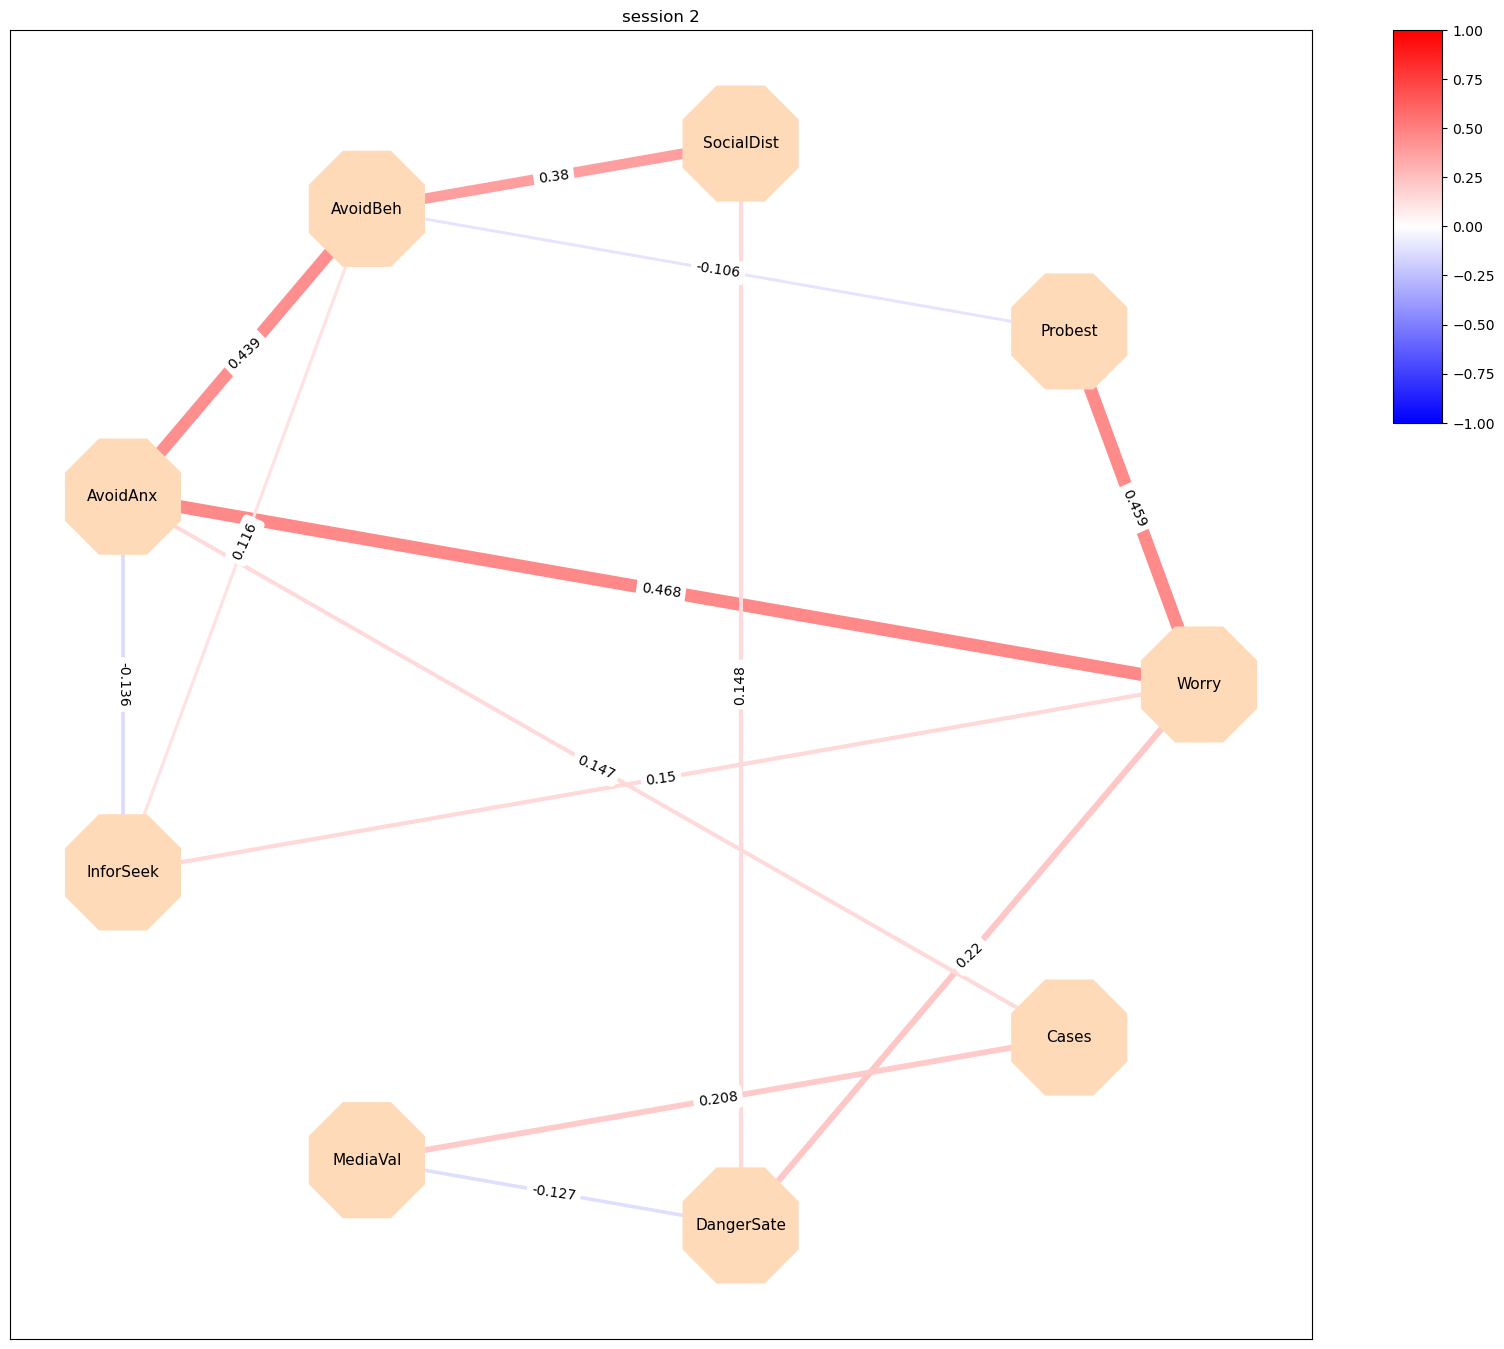

In [9]:
vars2 = vars+trait_factor_names
conf = {'mapdict':mapdict}

for s in [1]:#df["session"].unique():
    conf["f"], conf["ax"] = plt.subplots(1,1,figsize=(21,17))

    data = df.loc[df["session"]==s,vars2] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

    # calculate correlation matrix
    #corr = data.loc[:,vars2].corr(method=corr_type)
    corr = data.loc[:,vars].pcorr() #(method=corr_type)

    links = corr.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    tdf=links.loc[ (links['var1'] != links['var2']) ]
    tdf["var1"] = tdf["var1"].map(conf["mapdict"]) 
    tdf["var2"] = tdf["var2"].map(conf["mapdict"])
    Gtemp=nx.from_pandas_edgelist(tdf, 'var1', 'var2') 
    pos=nx.circular_layout(Gtemp)
    conf["first_layout"] = pos
    
    conf["sess"] = s
    conf["edgesize"] = 8000
    conf = plot_network(corr, conf)
    conf["ax"].set_title("session "+str(s+1))
    conf["f"].colorbar(conf["mapper"], shrink=0.3, anchor=(0,1), aspect=8)

 


In [10]:
#edge_labels = dict([((n1, n2), round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3))
#                    for n1, n2 in G.edges])
#edge_labels


In [11]:
#edge_intensities = [ round(float(links_filtered.query('var1==@n1 & var2==@n2')["value"]),3) for n1, n2 in G.edges]
#edge_intensities

### Partial conrrelations

In [12]:
plot_by_sess = False
if plot_by_sess:
    conf = {'mapdict':mapdict} 

    ## this just gets the same layout for all plots
    corr = df.loc[:,vars+trait_factor_names].corr()
    links = corr.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    tdf=links.loc[ (links['var1'] != links['var2']) ]
    tdf["var1"] = tdf["var1"].map(conf["mapdict"]) 
    tdf["var2"] = tdf["var2"].map(conf["mapdict"])
    Gtemp=nx.from_pandas_edgelist(tdf, 'var1', 'var2') 
    pos=nx.circular_layout(Gtemp)
    conf["first_layout"] = pos


    conf["edgesize"] = 3200

    pcordf = pd.DataFrame()
    for s in df["session"].unique():
        conf["f"], ax = plt.subplots(1,4,figsize=(30,8))
        for tt_idx, tt in enumerate(trait_factor_names):
            conf["ax"] = ax[tt_idx]
            vars2 = vars+[tt]
            
            data = df.loc[df["session"]==s,vars2] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

            # calculate correlation matrix
            #corr = data.loc[:,vars].corr(method=corr_type)
            #corr = data.loc[:,vars2].corr(method=corr_type)
            corr = data.loc[:,vars2].pcorr()
            
            # collect data 
            sdf = corr.loc[corr.columns.isin(trait_factor_names), ~corr.columns.isin(trait_factor_names)].reset_index()
            sdf["session"] = s
            pcordf = pd.concat([pcordf, sdf], axis=0)
            
            conf["sess"] = s
            conf = plot_network(corr, conf)
            conf["ax"].set_title(tt+" Session "+str(s+1))
        #conf["f"].colorbar(conf["mapper"], shrink=0.3, anchor=(0,1), aspect=8)


Worry
Probest
AvoidAnx
DangerSate
TF3_NegAff
SocialDist
AvoidBeh
Cases
InforSeek
MediaVal
Worry
Probest
AvoidAnx
DangerSate
TF2_SomAnx
SocialDist
AvoidBeh
Cases
InforSeek
MediaVal
Worry
Probest
AvoidAnx
DangerSate
TF1_CogAnx
SocialDist
AvoidBeh
Cases
InforSeek
MediaVal
Worry
Probest
AvoidAnx
DangerSate
TA
SocialDist
AvoidBeh
Cases
InforSeek
MediaVal
Worry
Probest
AvoidAnx
DangerSate
TF3_NegAff
SocialDist
AvoidBeh
InforSeek
MediaVal
Cases
Worry
Probest
AvoidAnx
DangerSate
TF2_SomAnx
SocialDist
AvoidBeh
InforSeek
MediaVal
Cases
Worry
Probest
AvoidAnx
DangerSate
TF1_CogAnx
SocialDist
AvoidBeh
InforSeek
MediaVal
Cases
Worry
Probest
AvoidAnx
DangerSate
TA
SocialDist
AvoidBeh
InforSeek
MediaVal
Cases
Worry
Probest
AvoidAnx
DangerSate
TF3_NegAff
SocialDist
AvoidBeh
InforSeek
MediaVal
Worry
Probest
AvoidAnx
DangerSate
TF2_SomAnx
SocialDist
AvoidBeh
InforSeek
MediaVal
Worry
Probest
AvoidAnx
DangerSate
TF1_CogAnx
SocialDist
AvoidBeh
InforSeek
MediaVal
Worry
Probest
AvoidAnx
DangerSate
TA
SocialD

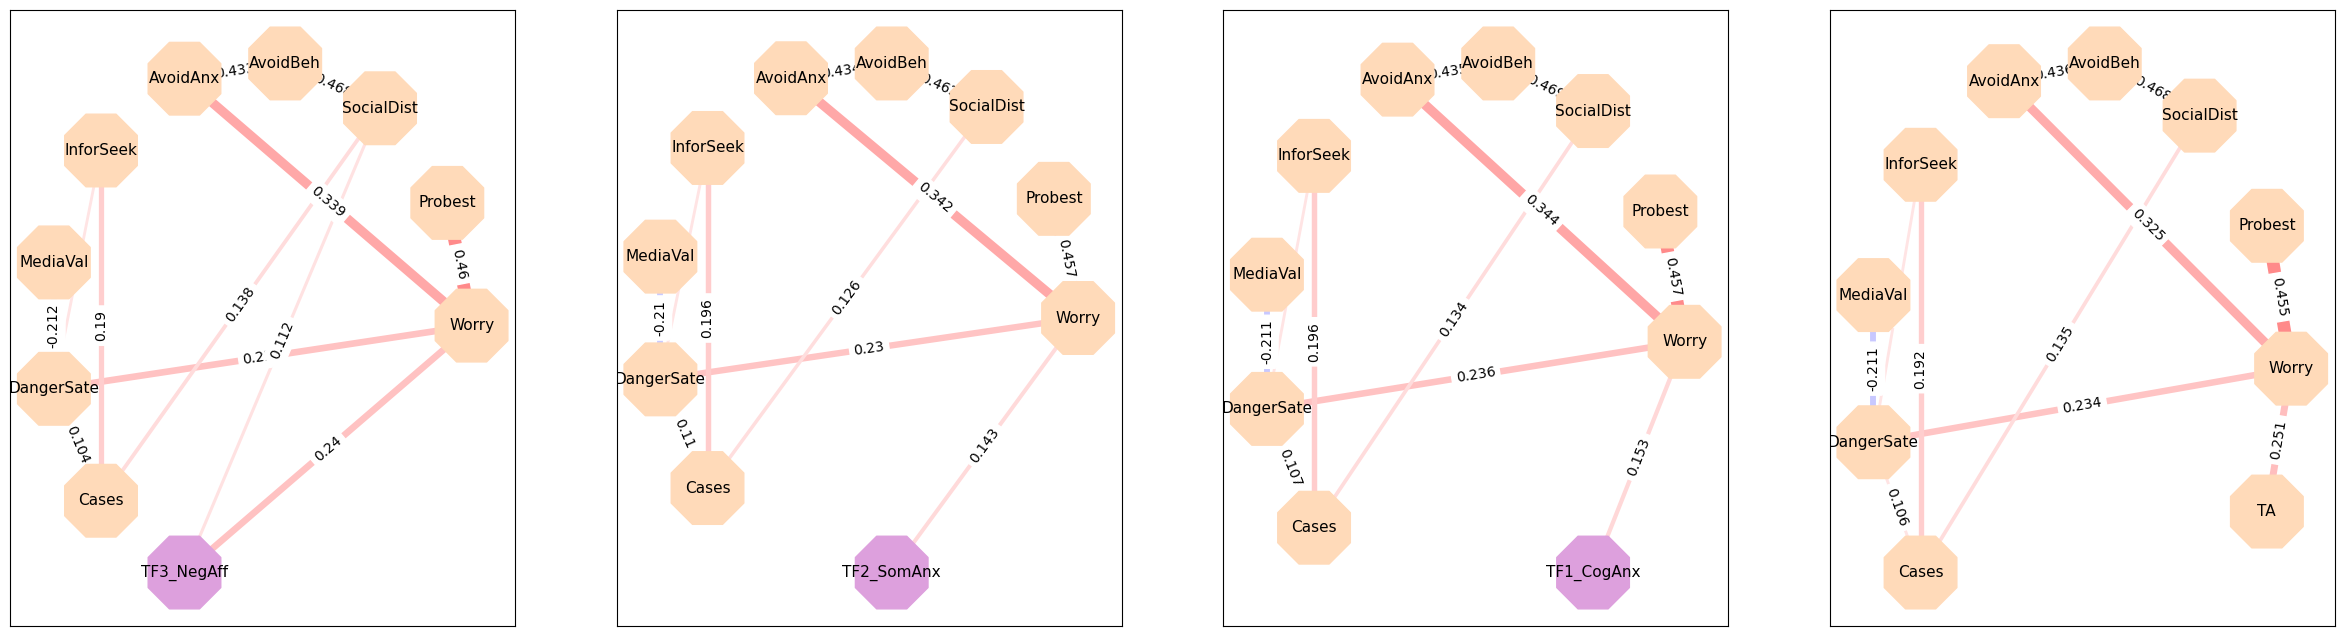

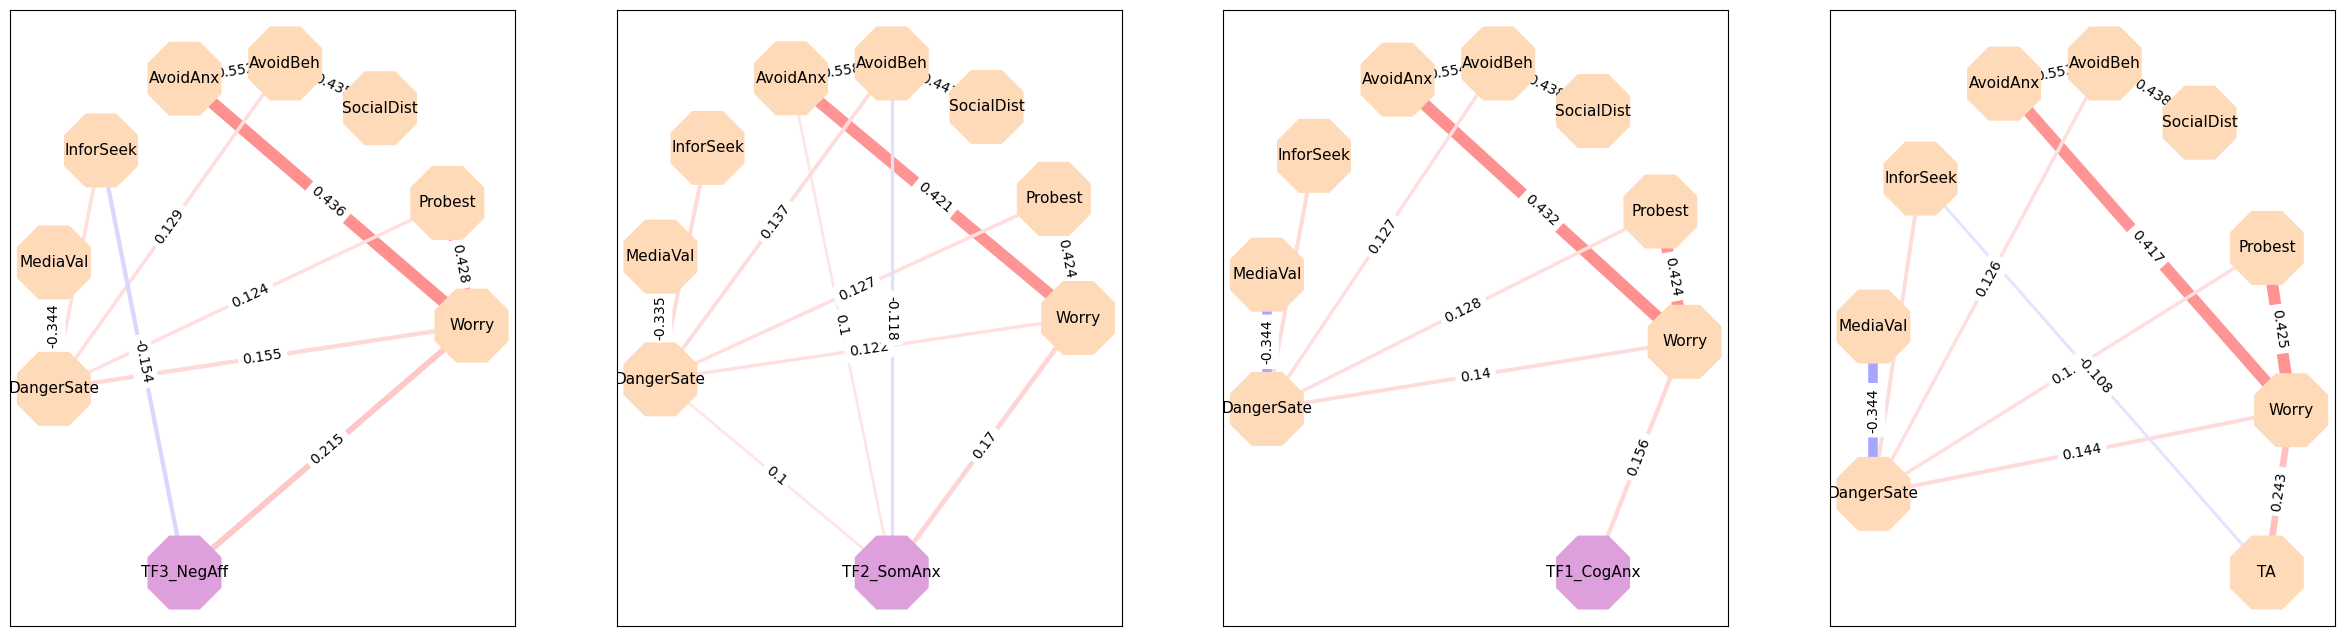

In [13]:
conf = {'mapdict':mapdict} 

## this just gets the same layout for all plots
corr = df.loc[:,vars+trait_factor_names].corr()
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
tdf=links.loc[ (links['var1'] != links['var2']) ]
tdf["var1"] = tdf["var1"].map(conf["mapdict"]) 
tdf["var2"] = tdf["var2"].map(conf["mapdict"])
Gtemp=nx.from_pandas_edgelist(tdf, 'var1', 'var2') 
pos=nx.circular_layout(Gtemp)
conf["first_layout"] = pos


conf["edgesize"] = 3200

pcordf = pd.DataFrame()
for s in df["wave"].unique():
    conf["f"], ax = plt.subplots(1,4,figsize=(30,8))
    for tt_idx, tt in enumerate(trait_factor_names):
        conf["ax"] = ax[tt_idx]
        vars2 = vars+[tt]
        
        data = df.loc[df["wave"]==s,vars2] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

        # calculate correlation matrix
        #corr = data.loc[:,vars].corr(method=corr_type)
        #corr = data.loc[:,vars2].corr(method=corr_type)
        corr = data.loc[:,vars2].pcorr()
        
        # collect data 
        sdf = corr.loc[corr.columns.isin(trait_factor_names), ~corr.columns.isin(trait_factor_names)].reset_index()
        sdf["session"] = s
        pcordf = pd.concat([pcordf, sdf], axis=0)
        
        conf["sess"] = s
        conf = plot_network(corr, conf)
        #conf["ax"].set_title(tt+" wave "+str(s+1))
    #conf["f"].colorbar(conf["mapper"], shrink=0.3, anchor=(0,1), aspect=8)

In [14]:
vars = [
"covid_worry", "prob_est", "q6_apply_soc_dist", 
 "avoid_beh", "avoid_anx", "q6_media_freq_num", 
"q6_media_valence", "q7_period_rel_danger", "deaths"]

### Partialling out only state factors

In [15]:
ppdf = pd.DataFrame()
for s in df["session"].unique():
    tdf = pd.DataFrame()
    for tt in trait_factor_names:
        vars2 = vars+[tt]
        # calculate correlation matrix
        corr = df.loc[df["session"]==s,vars2].pcorr()
        tdf = pd.concat([tdf,corr.loc[~corr.columns.isin(trait_factor_names), corr.columns.isin(trait_factor_names)]], axis=1)
    tdf["session"] = s
    ppdf = pd.concat([ppdf, tdf], axis=0)
ppdf = ppdf.reset_index()

### Partialling out also trait factors

Worry
Probest
AvoidAnx
DangerSate
TF1_CogAnx
TA
SocialDist
AvoidBeh
Deaths
InforSeek
MediaVal
TF3_NegAff
TF2_SomAnx


AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

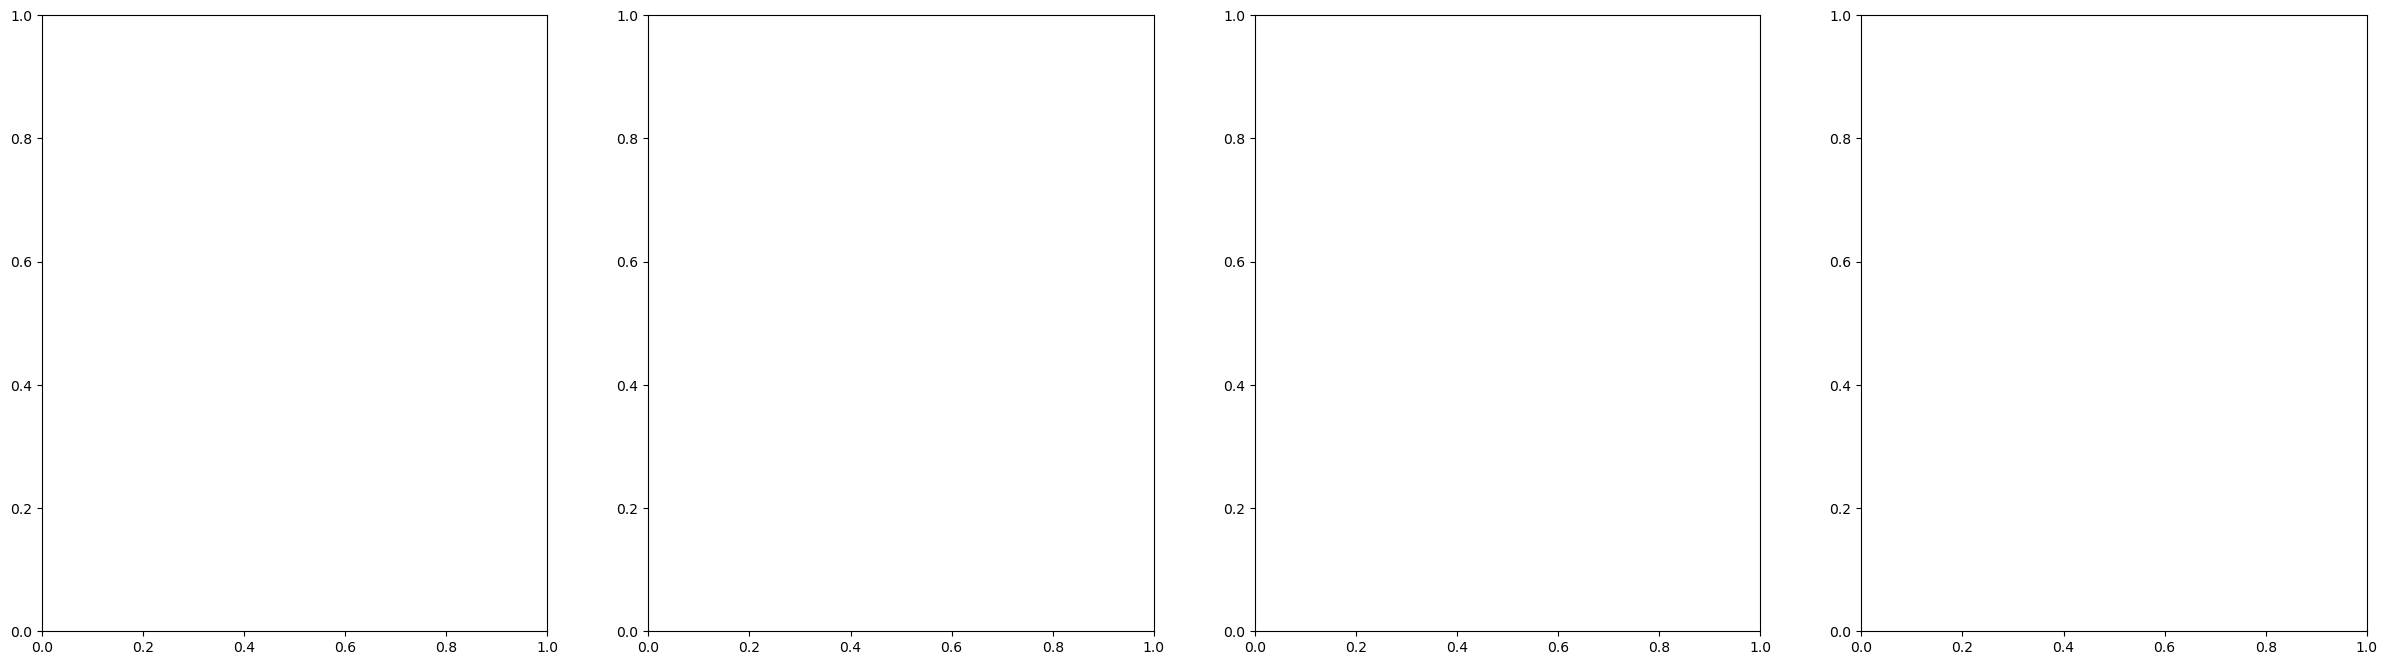

In [16]:
conf = {'mapdict':mapdict} 

## this just gets the same layout for all plots
corr = df.loc[:,vars+trait_factor_names].corr()
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
tdf=links.loc[ (links['var1'] != links['var2']) ]
tdf["var1"] = tdf["var1"].map(conf["mapdict"]) 
tdf["var2"] = tdf["var2"].map(conf["mapdict"])
Gtemp=nx.from_pandas_edgelist(tdf, 'var1', 'var2') 
pos=nx.circular_layout(Gtemp)
conf["first_layout"] = pos

pcordf = pd.DataFrame()
conf["edgesize"] = 3200

for s in df["wave"].unique():
    conf["f"], conf["ax"] = plt.subplots(1,4,figsize=(30,8))
    vars2 = vars+trait_factor_names

    # calculate correlation matrix
    corr = df.loc[df["wave"]==s,vars2].pcorr()
    
    # collect data 
    sdf = corr.loc[~corr.columns.isin(trait_factor_names), corr.columns.isin(trait_factor_names)].reset_index()
    sdf["wave"] = s
    pcordf = pd.concat([pcordf, sdf], axis=0)
    #conf["f"].colorbar(conf["mapper"], shrink=0.3, anchor=(0,1), aspect=8)
    conf["wave"] = s
    conf = plot_network(corr, conf)


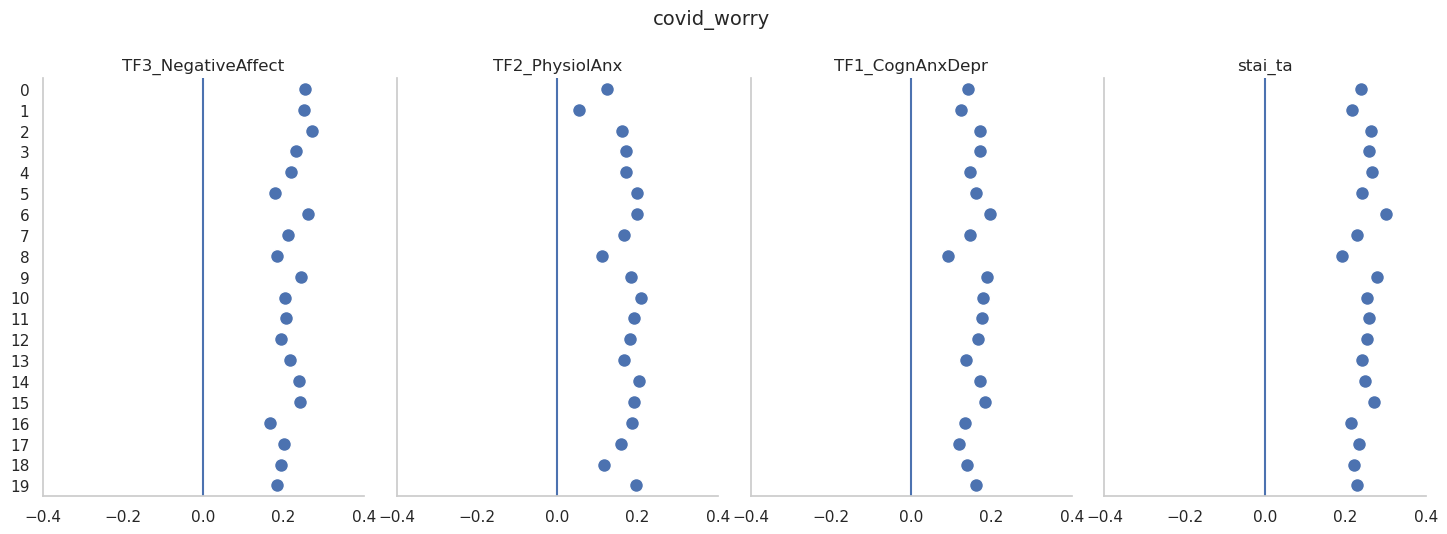

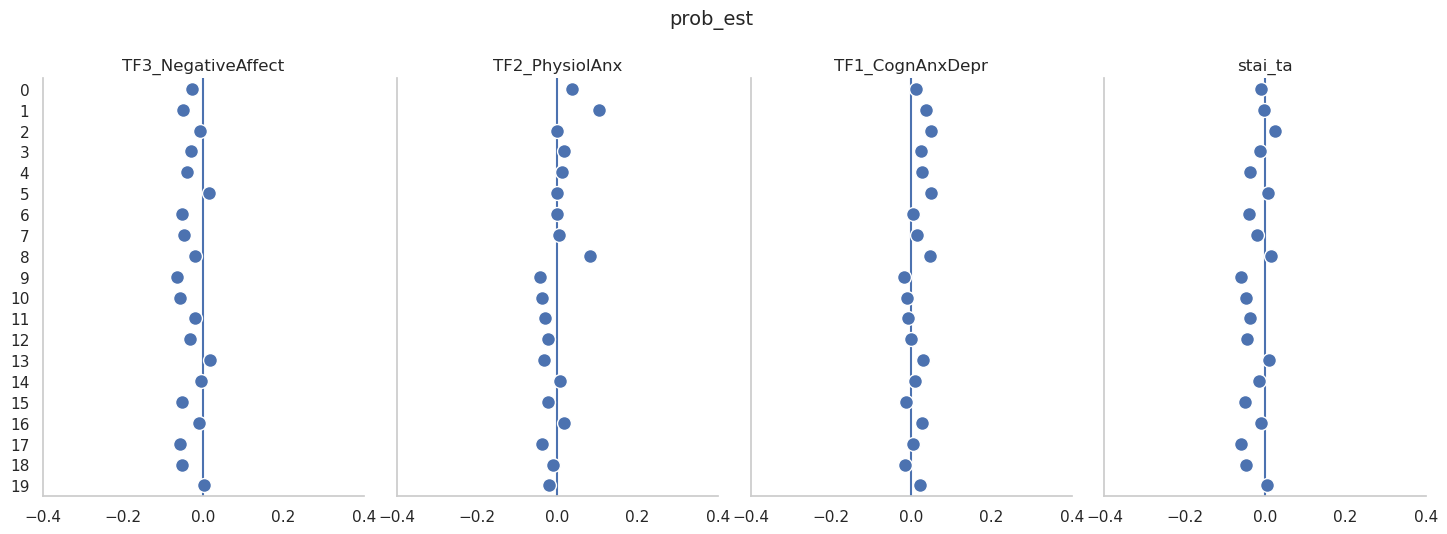

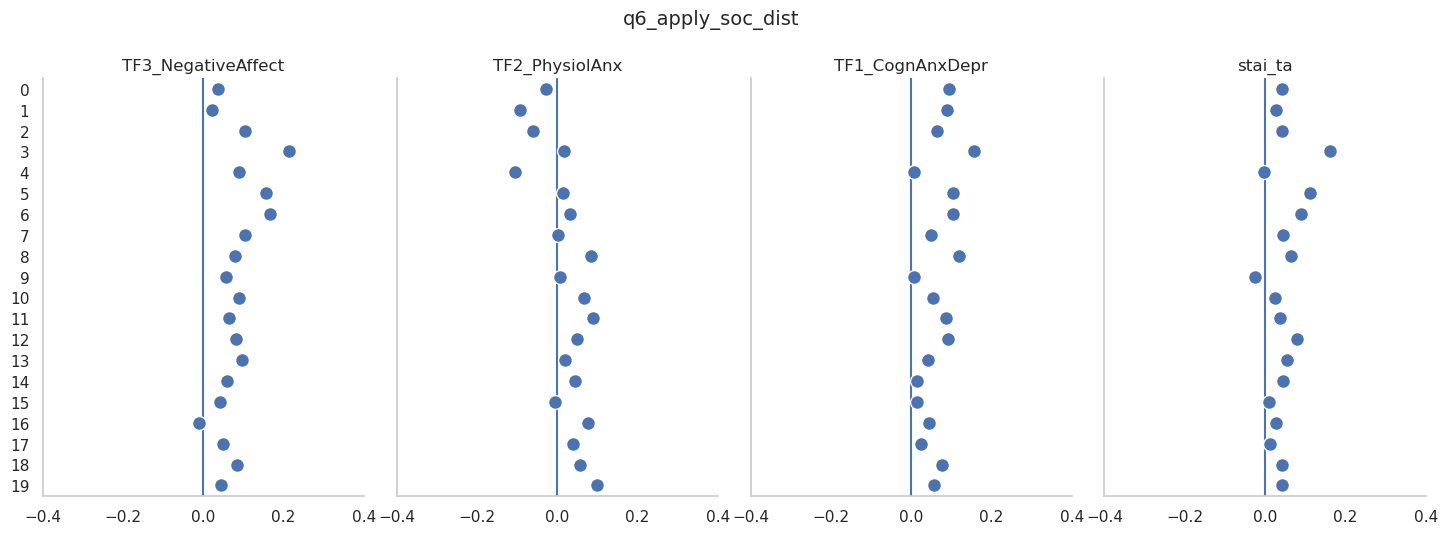

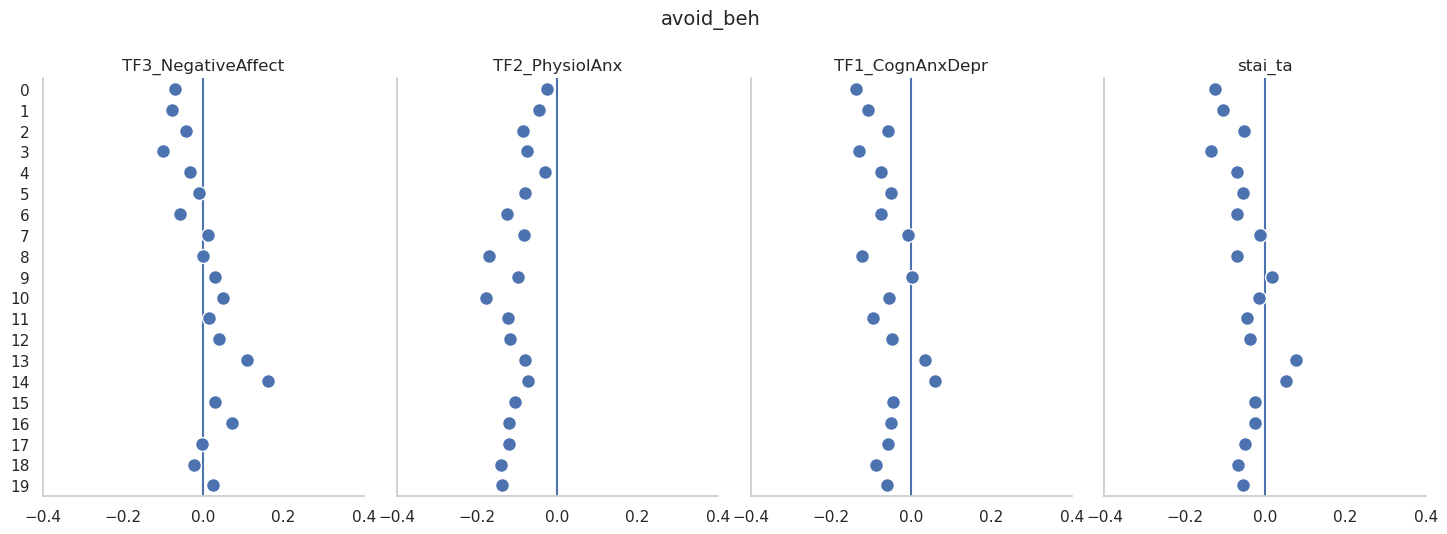

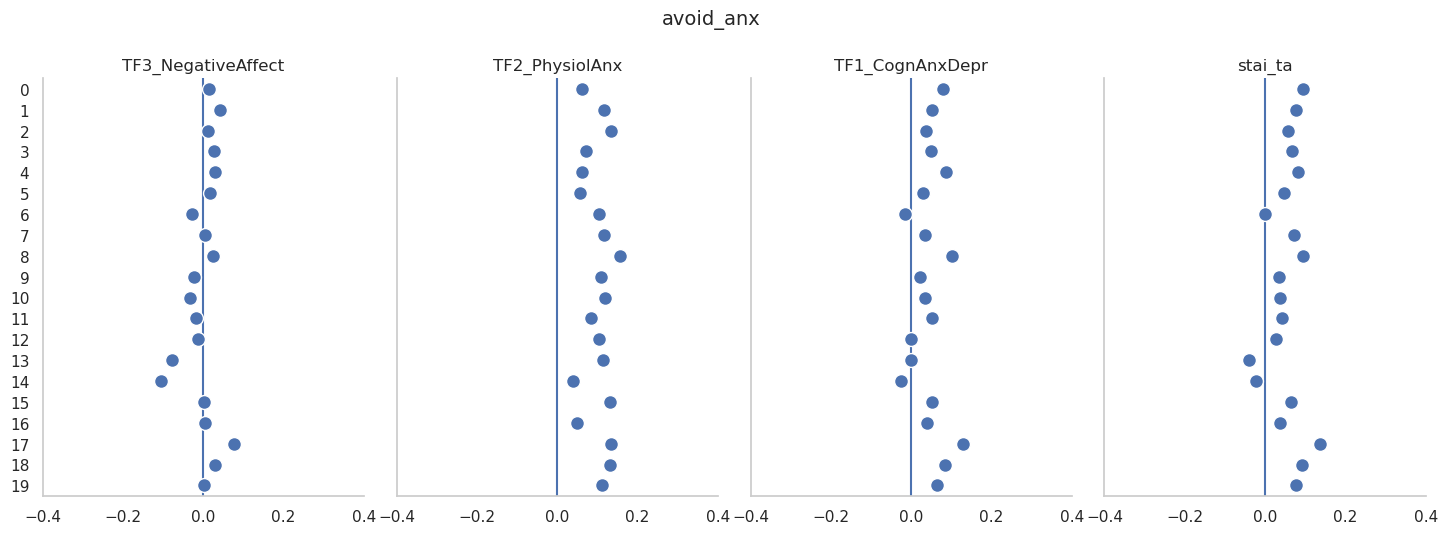

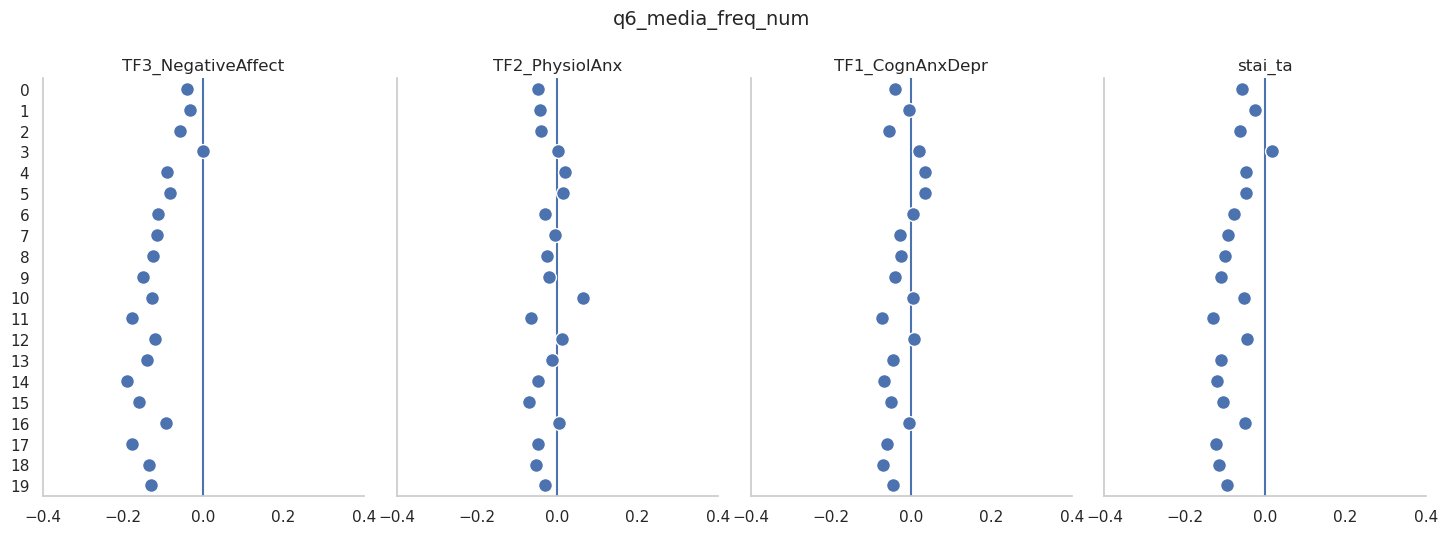

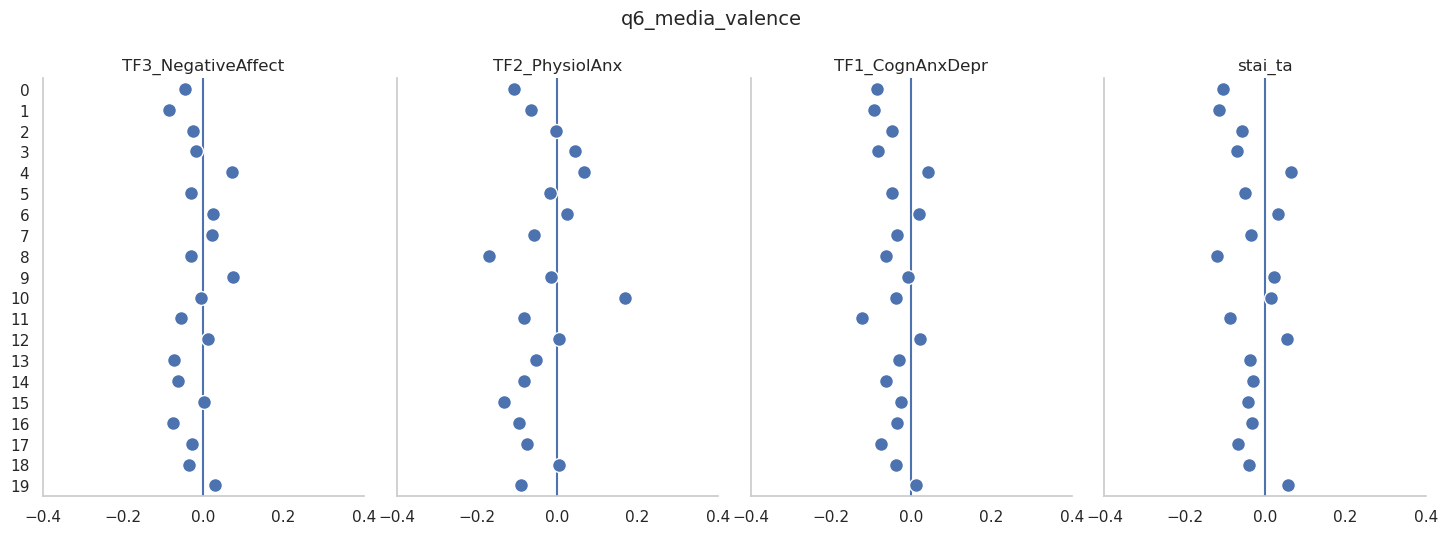

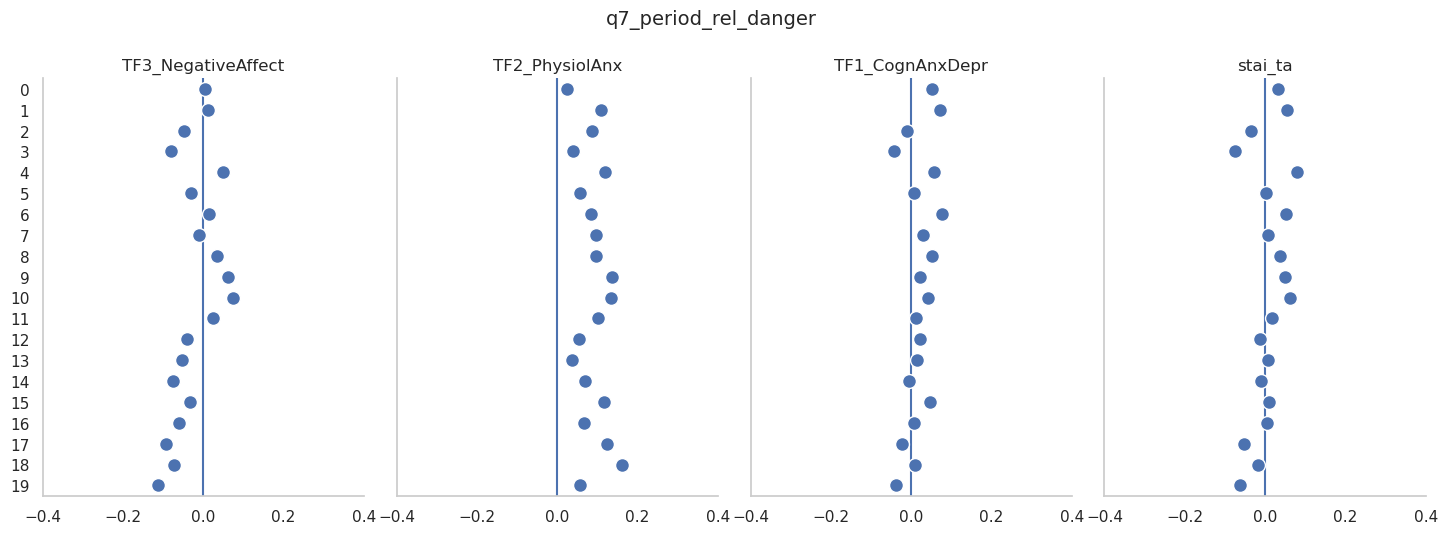

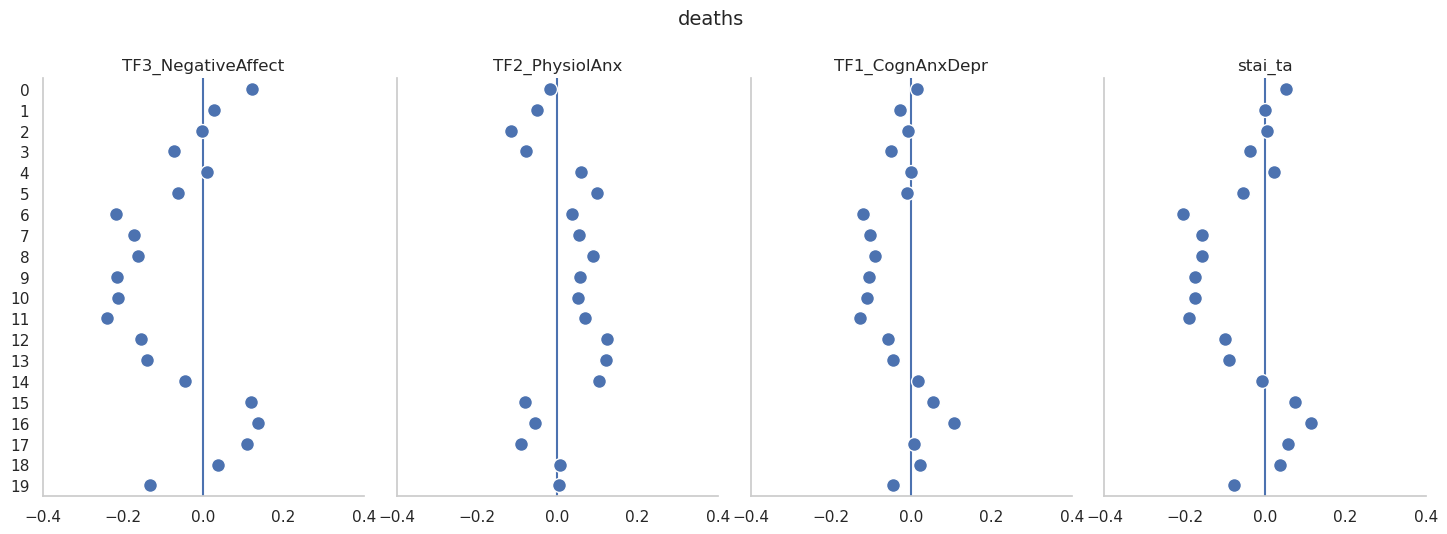

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

for v in vars:
      #tdf = pcordf.loc[pcordf["index"]==v, ]
      tdf = ppdf.loc[ppdf["index"]==v, ]

      # Load the dataset
      #crashes = sns.load_dataset("car_crashes")

      # Make the PairGrid
      g = sns.PairGrid(tdf.sort_values("session", ascending=False),
                  x_vars=trait_factor_names, y_vars=["session"],
                  height=5, aspect=.75)

      # Draw a dot plot using the stripplot function
      g.map(sns.stripplot,  size=10, orient="h", jitter=False,
            palette="flare_r", linewidth=1, edgecolor="w")

      # Use the same x axis limits on all columns and add better labels
      g.set(xlim=(-0.4, 0.4), xlabel="", ylabel="")


      for ax, title in zip(g.axes.flat, trait_factor_names):
            # Set a different title for each axes
            ax.set(title=title)

            # Make the grid horizontal instead of vertical
            ax.xaxis.grid(False)
            ax.yaxis.grid(False)
            ax.axvline(0, 0,20)
      plt.suptitle(v, y=1.1, fontsize=14)


